In [1]:
import sys
import torch

print(f"Python executable: {sys.executable}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
CUDA available: False


In [2]:
import os
import sam3

sam3_root = os.path.join(os.path.dirname(sam3.__file__))
device = "cuda" if torch.cuda.is_available() else "cpu"

INFO 2026-02-25 21:12:32,326 380479 __globals.py:  12: Python executable: /home/prashant/repo/public/sam3-cpu/.venv/bin/python
INFO 2026-02-25 21:12:32,326 380479 __globals.py:  13: CUDA available: False
INFO 2026-02-25 21:12:32,326 380479 __globals.py:  25: ⚡ Profiling DISABLED (use --profile to enable)



In [3]:
bpe_path = os.path.join(sam3_root, "assets/bpe_simple_vocab_16e6.txt.gz")
num_workers = 1 if device == "cpu" else 0
if device == "cpu":
    from sam3.model_builder import build_sam3_video_predictor_cpu
    print("Running on CPU. For better performance, please run on a GPU.")
    predictor = build_sam3_video_predictor_cpu(bpe_path=bpe_path, num_workers=num_workers)
else:
    from sam3.model_builder import build_sam3_video_predictor
    print("Running on GPU")
    predictor = build_sam3_video_predictor()

INFO 2026-02-25 21:12:34,217 380479 sam3_video_predictor_v2.py: 597: using 1 CPU workers for parallel inference
INFO 2026-02-25 21:12:34,218 380479 sam3_video_predictor_v2.py: 612: 


	*** START loading model on all ranks ***


INFO 2026-02-25 21:12:34,218 380479 sam3_video_predictor_v2.py: 614: loading model on rank=0 with world_size=1 -- this could take a while ...


Running on CPU. For better performance, please run on a GPU.


INFO 2026-02-25 21:12:39,222 380479 sam3_video_base.py: 125: setting max_num_objects=10000 and num_obj_for_compile=16
INFO 2026-02-25 21:12:40,650 380479 sam3_video_predictor_v2.py: 618: loading model on rank=0 with world_size=1 -- DONE locally
INFO 2026-02-25 21:12:40,651 380479 sam3_video_predictor_v2.py: 628: 


	*** DONE loading model on all ranks ***




# Inference, Visualization & Cross-Chunk ID Matching Utils

In [4]:
import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sam3.visualization_utils import (
    load_frame,
    prepare_masks_for_visualization,
    visualize_formatted_frame_output,
)

# font size for axes titles
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["figure.titlesize"] = 12


def propagate_in_video(predictor, session_id, max_frames=None):
    """Propagate from frame 0, returns raw outputs_per_frame dict."""
    outputs_per_frame = {}
    for response in predictor.handle_stream_request(
        request=dict(
            type="propagate_in_video",
            session_id=session_id,
            start_frame_index=0,
            max_frame_num_to_track=max_frames,
        )
    ):
        outputs_per_frame[response["frame_index"]] = response["outputs"]
    return outputs_per_frame


def abs_to_rel_coords(coords, IMG_WIDTH, IMG_HEIGHT, coord_type="point"):
    """Convert absolute coordinates to relative coordinates (0-1 range)."""
    if coord_type == "point":
        return [[x / IMG_WIDTH, y / IMG_HEIGHT] for x, y in coords]
    elif coord_type == "box":
        return [
            [x / IMG_WIDTH, y / IMG_HEIGHT, w / IMG_WIDTH, h / IMG_HEIGHT]
            for x, y, w, h in coords
        ]
    else:
        raise ValueError(f"Unknown coord_type: {coord_type}")


# ── Cross-chunk IoU helpers ──────────────────────────────────────────────


def compute_iou(mask_a: np.ndarray, mask_b: np.ndarray) -> float:
    """Compute IoU between two binary/uint8 masks."""
    a = mask_a > 127 if mask_a.dtype == np.uint8 else mask_a.astype(bool)
    b = mask_b > 127 if mask_b.dtype == np.uint8 else mask_b.astype(bool)
    intersection = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return float(intersection / union) if union > 0 else 0.0


def extract_frame_masks(outputs, object_ids, frame_idx=None):
    """Extract per-object masks from a specific frame (default: last frame)."""
    if not outputs:
        return {}
    if frame_idx is None:
        frame_idx = max(outputs.keys())
    out = outputs.get(frame_idx)
    if out is None:
        return {}
    out_obj_ids = out.get("out_obj_ids", [])
    if isinstance(out_obj_ids, np.ndarray):
        out_obj_ids = out_obj_ids.tolist()
    masks = {}
    for obj_id in object_ids:
        if obj_id in out_obj_ids:
            try:
                idx = out_obj_ids.index(obj_id)
                mask_bool = out["out_binary_masks"][idx]
                masks[obj_id] = (mask_bool.astype(np.uint8) * 255)
            except (IndexError, ValueError):
                pass
    return masks


def apply_id_mapping(outputs, id_mapping):
    """Remap object IDs across all frames in an outputs dict."""
    remapped = {}
    for frame_idx, output in outputs.items():
        out_obj_ids = output.get("out_obj_ids", [])
        if isinstance(out_obj_ids, np.ndarray):
            out_obj_ids = out_obj_ids.tolist()
        else:
            out_obj_ids = list(out_obj_ids)
        mapped = [id_mapping.get(oid, oid) for oid in out_obj_ids]
        remapped_output = dict(output)
        remapped_output["out_obj_ids"] = np.array(mapped, dtype=np.int64)
        remapped[frame_idx] = remapped_output
    return remapped


def match_and_remap_ids(outputs, object_ids, prev_last_masks, global_next_id,
                         iou_threshold=0.25):
    """
    IoU-match this chunk's first-frame masks against previous chunk's
    last-frame masks, then remap IDs so the same physical object keeps
    the same global ID across chunks.

    Returns (remapped_outputs, remapped_ids, id_mapping, updated_global_next_id).
    """
    if not outputs or not prev_last_masks:
        id_mapping = {}
        for oid in sorted(object_ids):
            id_mapping[oid] = global_next_id
            global_next_id += 1
        return apply_id_mapping(outputs, id_mapping), set(id_mapping.values()), id_mapping, global_next_id

    first_frame_masks = extract_frame_masks(outputs, object_ids, frame_idx=min(outputs.keys()))

    # Score all (new, prev) pairs
    pairs = []
    for new_id, new_mask in first_frame_masks.items():
        for prev_id, prev_mask in prev_last_masks.items():
            iou = compute_iou(new_mask, prev_mask)
            if iou >= iou_threshold:
                pairs.append((iou, new_id, prev_id))
    pairs.sort(reverse=True)

    id_mapping = {}
    used_prev = set()
    for iou, new_id, prev_id in pairs:
        if new_id in id_mapping or prev_id in used_prev:
            continue
        id_mapping[new_id] = prev_id
        used_prev.add(prev_id)
        print(f"  ✓ chunk_obj_{new_id} → global_obj_{prev_id} (IoU={iou:.3f})")

    for oid in sorted(object_ids):
        if oid not in id_mapping:
            id_mapping[oid] = global_next_id
            print(f"  + chunk_obj_{oid} → global_obj_{global_next_id} (new)")
            global_next_id += 1

    remapped = apply_id_mapping(outputs, id_mapping)
    return remapped, set(id_mapping.values()), id_mapping, global_next_id

## Load video chunks

In [5]:
# Point to the folder containing chunk_*.mp4 files
video_chunk_path = os.path.join(sam3_root, "../assets/videos/private/wimbledon_720p_chunks/")

video_chunks = sorted(glob.glob(os.path.join(video_chunk_path, "*.mp4")))
print(f"Found {len(video_chunks)} video chunks in {video_chunk_path}")
for i, p in enumerate(video_chunks):
    cap = cv2.VideoCapture(p)
    nf = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    print(f"  [{i}] {os.path.basename(p)}: {w}×{h}, {nf} frames")

Found 5 video chunks in /home/prashant/repo/public/sam3-cpu/sam3/../assets/videos/private/wimbledon_720p_chunks/
  [0] chunk_000.mp4: 1280×720, 25 frames
  [1] chunk_001.mp4: 1280×720, 25 frames
  [2] chunk_002.mp4: 1280×720, 25 frames
  [3] chunk_003.mp4: 1280×720, 25 frames
  [4] chunk_004.mp4: 1280×720, 25 frames


In [6]:
prompt_text_str = "player"  # change to any text prompt you want
print(f"Prompt: '{prompt_text_str}'")

Prompt: 'player'


In [7]:
## Process all chunks with cross-chunk ID consistency

For each chunk we:
1. Start a fresh session and run the text prompt + propagation (chunk-local IDs)
2. IoU-match first-frame masks of chunk N+1 against last-frame masks of chunk N
3. Remap all IDs so the same physical object keeps the same global ID

SyntaxError: invalid syntax (2193602147.py, line 3)

In [8]:
prev_last_masks = None   # carry-forward masks from chunk N → N+1
global_next_id = 0       # monotonically increasing ID counter

chunk_results = []  # store (remapped_outputs, remapped_ids, video_frames) per chunk

for chunk_idx, chunk_path in enumerate(video_chunks):
    print(f"\n{'─'*60}")
    print(f"Chunk {chunk_idx}: {os.path.basename(chunk_path)}")
    print(f"{'─'*60}")

    # ── load frames for visualisation ──
    cap = cv2.VideoCapture(chunk_path)
    frames_vis = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frames_vis.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    cap.release()
    print(f"  Loaded {len(frames_vis)} frames for visualisation")

    # ── start session ──
    response = predictor.handle_request(
        request=dict(type="start_session", resource_path=chunk_path)
    )
    session_id = response["session_id"]

    # ── add prompt & propagate (chunk-local IDs) ──
    _ = predictor.handle_request(
        request=dict(type="reset_session", session_id=session_id)
    )
    _ = predictor.handle_request(
        request=dict(
            type="add_prompt",
            session_id=session_id,
            frame_index=0,
            text=prompt_text_str,
        )
    )
    outputs = propagate_in_video(predictor, session_id)

    raw_obj_ids = set()
    for out in outputs.values():
        ids = out.get("out_obj_ids", [])
        if isinstance(ids, np.ndarray):
            ids = ids.tolist()
        raw_obj_ids.update(ids)
    print(f"  Raw object IDs (chunk-local): {sorted(raw_obj_ids)}")

    # ── IoU-based ID remapping ──
    if chunk_idx == 0:
        # First chunk: assign initial sequential global IDs
        id_mapping = {}
        for oid in sorted(raw_obj_ids):
            id_mapping[oid] = global_next_id
            global_next_id += 1
        outputs = apply_id_mapping(outputs, id_mapping)
        remapped_ids = set(id_mapping.values())
        print(f"  Global IDs (initial): {sorted(remapped_ids)}")
    else:
        # Subsequent chunks: IoU-match against previous chunk
        outputs, remapped_ids, id_mapping, global_next_id = match_and_remap_ids(
            outputs, raw_obj_ids, prev_last_masks, global_next_id,
        )
        continued = sorted(set(id_mapping.values()) & set(prev_last_masks.keys()))
        new_ids   = sorted(set(id_mapping.values()) - set(prev_last_masks.keys()))
        print(f"  Continued: {continued}")
        if new_ids:
            print(f"  New:       {new_ids}")

    # ── extract last-frame masks for next chunk ──
    prev_last_masks = extract_frame_masks(outputs, remapped_ids)
    non_empty = sum(1 for m in prev_last_masks.values() if m.any())
    print(f"  Carry-forward: {len(prev_last_masks)} masks ({non_empty} non-empty)")

    # ── close session ──
    _ = predictor.handle_request(
        request=dict(type="close_session", session_id=session_id)
    )

    chunk_results.append((outputs, remapped_ids, frames_vis))

print(f"\n{'═'*60}")
print(f"Done – processed {len(chunk_results)} chunks with consistent IDs")
print(f"{'═'*60}")


────────────────────────────────────────────────────────────
Chunk 0: chunk_000.mp4
────────────────────────────────────────────────────────────
  Loaded 25 frames for visualisation


frame loading (OpenCV) [rank=0]: 100%|██████████| 25/25 [00:00<00:00, 632.06it/s]


propagate_in_video:   0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  Raw object IDs (chunk-local): [0, 1, 3]
  Global IDs (initial): [0, 1, 2]
  Carry-forward: 3 masks (3 non-empty)


INFO 2026-02-25 21:14:55,331 380479 sam3_video_predictor_v2.py: 294: removed session cdc17e1a-54bc-41ae-82c7-a58ea61cdbd4; live sessions: [], CPU memory: 7715 MiB used



────────────────────────────────────────────────────────────
Chunk 1: chunk_001.mp4
────────────────────────────────────────────────────────────
  Loaded 25 frames for visualisation


frame loading (OpenCV) [rank=0]: 100%|██████████| 25/25 [00:00<00:00, 659.55it/s]


propagate_in_video:   0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  Raw object IDs (chunk-local): [0, 1, 2, 3]
  ✓ chunk_obj_1 → global_obj_1 (IoU=0.950)
  ✓ chunk_obj_0 → global_obj_0 (IoU=0.916)
  ✓ chunk_obj_2 → global_obj_2 (IoU=0.868)
  + chunk_obj_3 → global_obj_3 (new)
  Continued: [0, 1, 2]
  New:       [3]
  Carry-forward: 4 masks (4 non-empty)


INFO 2026-02-25 21:16:27,570 380479 sam3_video_predictor_v2.py: 294: removed session 4e9289e3-ef97-49b9-b75a-bf814ef64c48; live sessions: [], CPU memory: 7793 MiB used



────────────────────────────────────────────────────────────
Chunk 2: chunk_002.mp4
────────────────────────────────────────────────────────────
  Loaded 25 frames for visualisation


frame loading (OpenCV) [rank=0]: 100%|██████████| 25/25 [00:00<00:00, 728.14it/s]


propagate_in_video:   0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  Raw object IDs (chunk-local): [0, 3, 4, 5]
  ✓ chunk_obj_3 → global_obj_0 (IoU=0.954)
  ✓ chunk_obj_0 → global_obj_1 (IoU=0.939)
  ✓ chunk_obj_4 → global_obj_2 (IoU=0.889)
  + chunk_obj_5 → global_obj_4 (new)
  Continued: [0, 1, 2]
  New:       [4]
  Carry-forward: 4 masks (4 non-empty)


INFO 2026-02-25 21:18:13,721 380479 sam3_video_predictor_v2.py: 294: removed session c4d3a65a-3a39-4100-87ba-c86fea5a5030; live sessions: [], CPU memory: 8148 MiB used



────────────────────────────────────────────────────────────
Chunk 3: chunk_003.mp4
────────────────────────────────────────────────────────────
  Loaded 25 frames for visualisation


frame loading (OpenCV) [rank=0]: 100%|██████████| 25/25 [00:00<00:00, 665.79it/s]


propagate_in_video:   0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  Raw object IDs (chunk-local): [0, 1, 2, 3, 4, 5]
  ✓ chunk_obj_2 → global_obj_2 (IoU=0.938)
  ✓ chunk_obj_1 → global_obj_0 (IoU=0.898)
  ✓ chunk_obj_0 → global_obj_1 (IoU=0.887)
  + chunk_obj_3 → global_obj_5 (new)
  + chunk_obj_4 → global_obj_6 (new)
  + chunk_obj_5 → global_obj_7 (new)
  Continued: [0, 1, 2]
  New:       [5, 6, 7]
  Carry-forward: 6 masks (6 non-empty)


INFO 2026-02-25 21:19:59,688 380479 sam3_video_predictor_v2.py: 294: removed session 1fa83155-12c5-4230-9b1c-a0c3872bf6fa; live sessions: [], CPU memory: 8315 MiB used



────────────────────────────────────────────────────────────
Chunk 4: chunk_004.mp4
────────────────────────────────────────────────────────────
  Loaded 25 frames for visualisation


frame loading (OpenCV) [rank=0]: 100%|██████████| 25/25 [00:00<00:00, 644.63it/s]


propagate_in_video:   0%|          | 0/25 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  Raw object IDs (chunk-local): [0, 1, 2, 3, 4, 5]
  ✓ chunk_obj_2 → global_obj_1 (IoU=0.958)
  ✓ chunk_obj_4 → global_obj_7 (IoU=0.949)
  ✓ chunk_obj_1 → global_obj_5 (IoU=0.947)
  ✓ chunk_obj_3 → global_obj_2 (IoU=0.935)
  ✓ chunk_obj_0 → global_obj_0 (IoU=0.906)
  + chunk_obj_5 → global_obj_8 (new)
  Continued: [0, 1, 2, 5, 7]
  New:       [8]
  Carry-forward: 6 masks (6 non-empty)


INFO 2026-02-25 21:21:52,303 380479 sam3_video_predictor_v2.py: 294: removed session 724e010b-2725-4728-8a50-cd120b768f69; live sessions: [], CPU memory: 8286 MiB used



════════════════════════════════════════════════════════════
Done – processed 5 chunks with consistent IDs
════════════════════════════════════════════════════════════


## Visualise results per chunk

Each subplot shows the segmentation masks with **globally consistent** object IDs.
The same physical object keeps the same ID (and colour) across chunk boundaries.


── Chunk 0 ── Object IDs: [0, 1, 2]


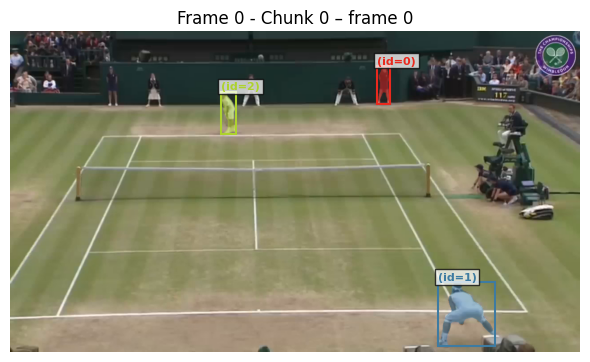

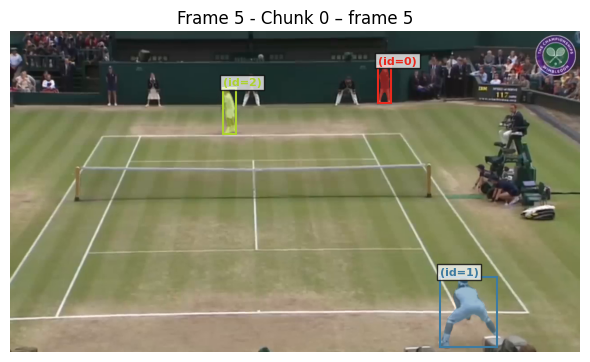

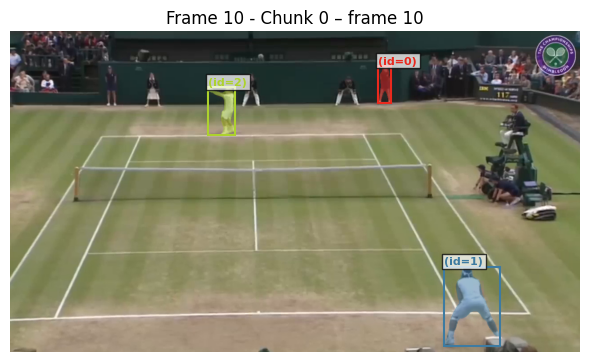

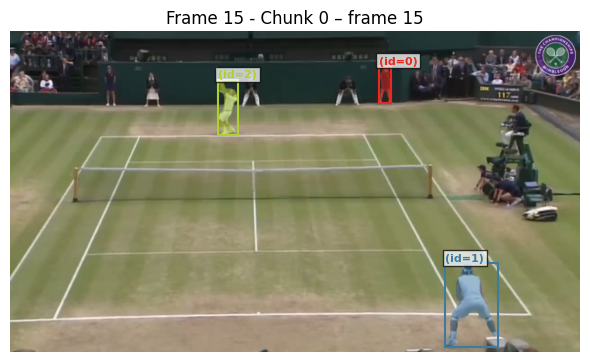

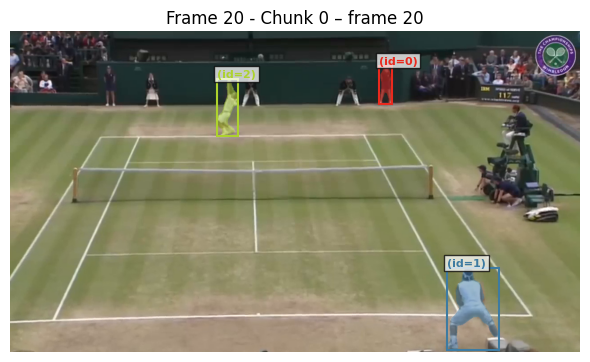


── Chunk 1 ── Object IDs: [0, 1, 2, 3]


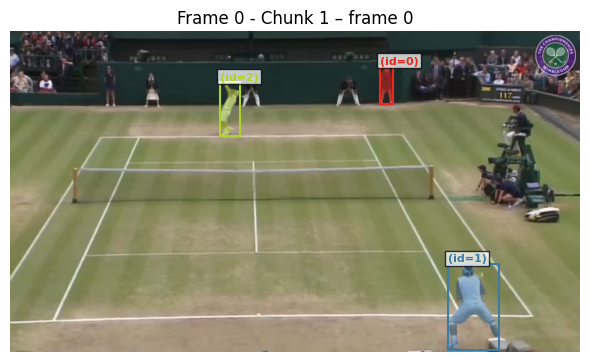

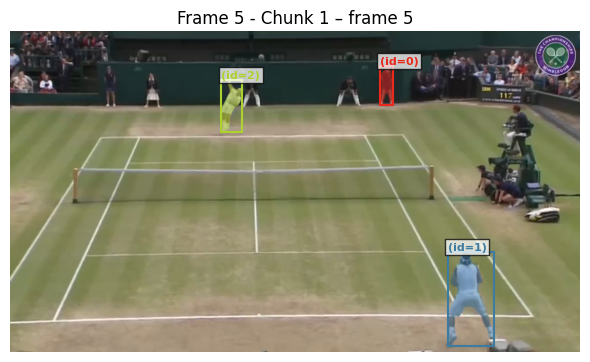

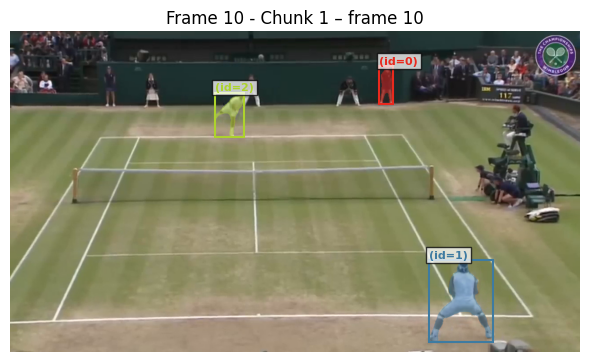

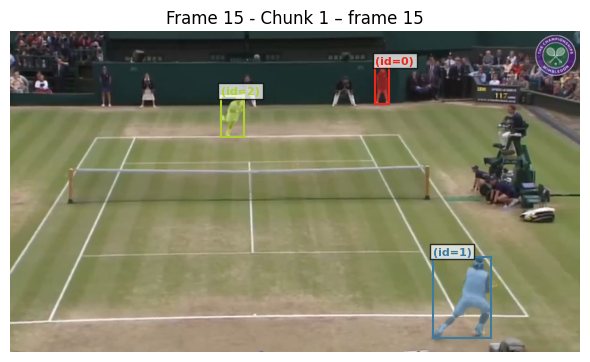

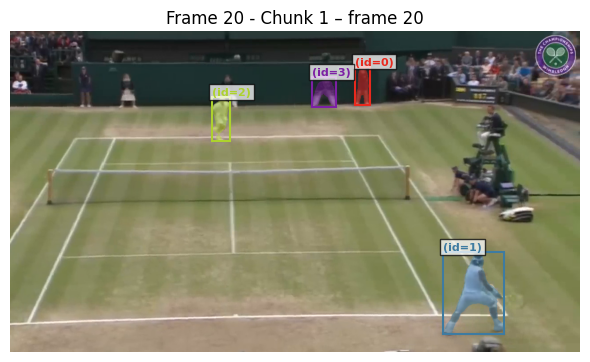


── Chunk 2 ── Object IDs: [0, 1, 2, 4]


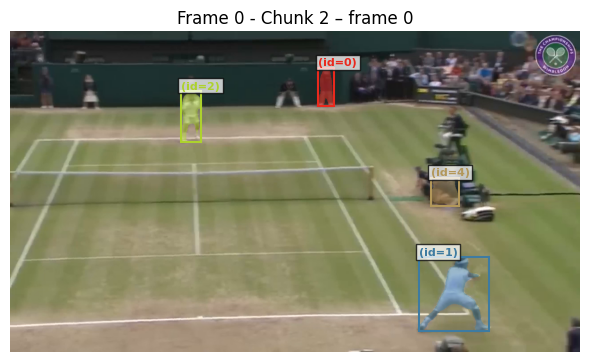

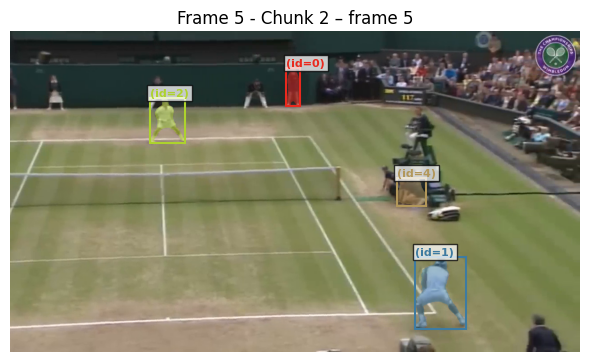

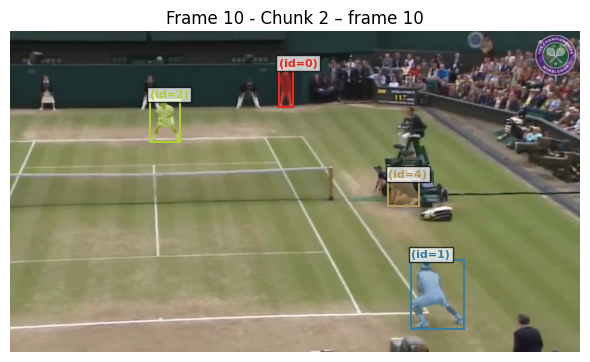

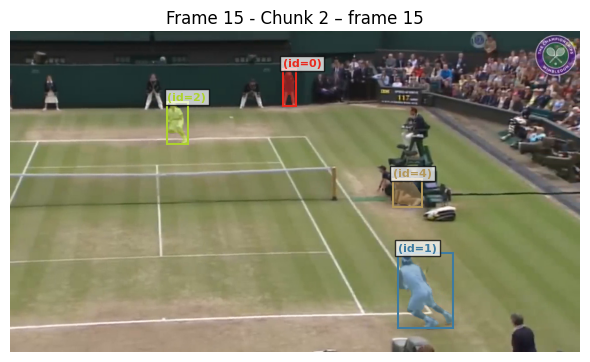

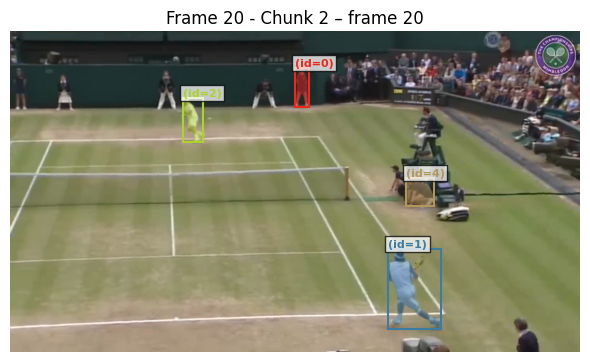


── Chunk 3 ── Object IDs: [0, 1, 2, 5, 6, 7]


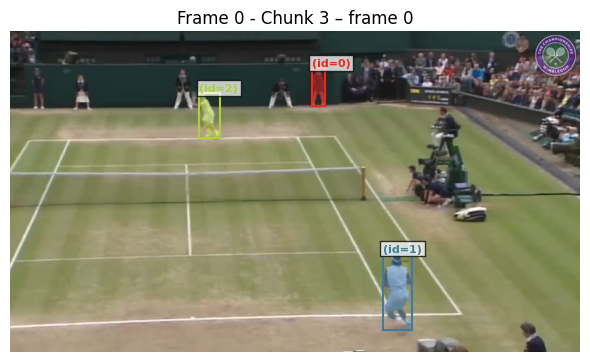

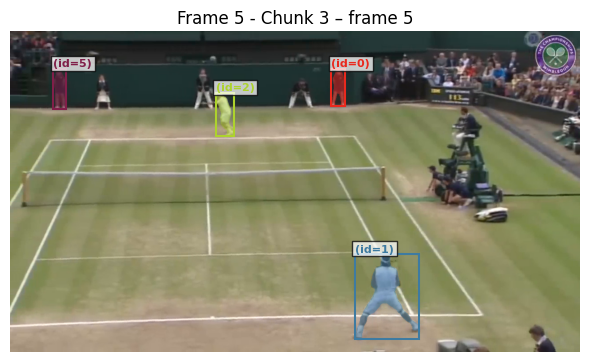

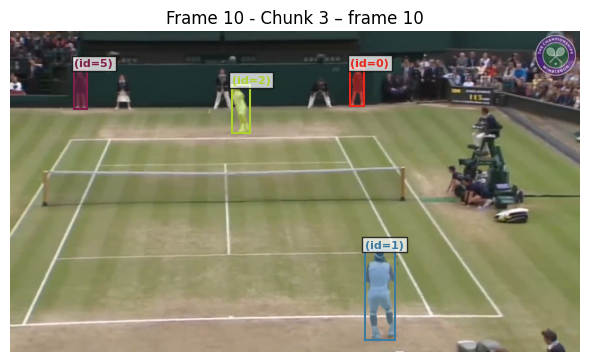

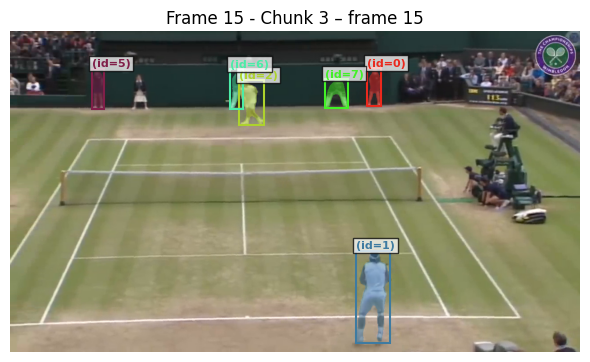

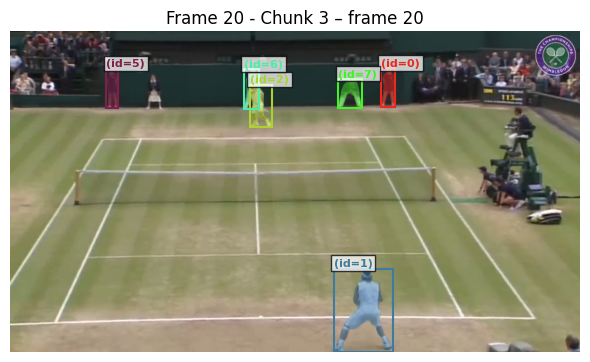


── Chunk 4 ── Object IDs: [0, 1, 2, 5, 7, 8]


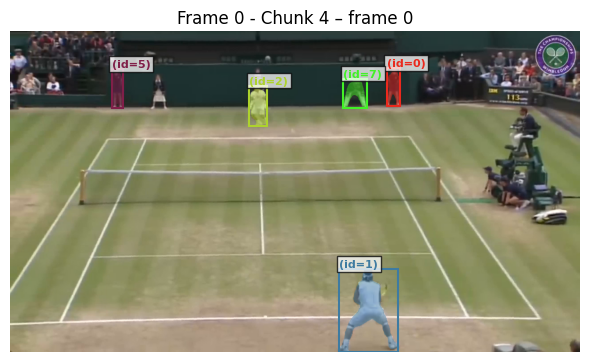

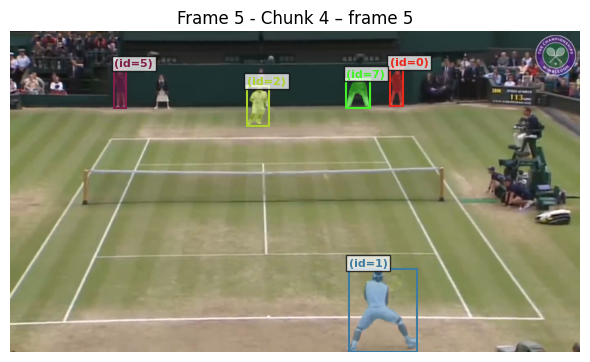

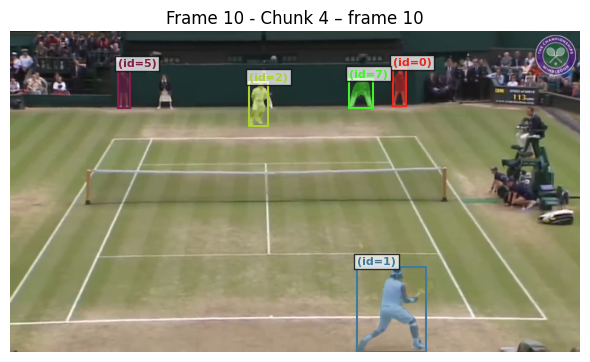

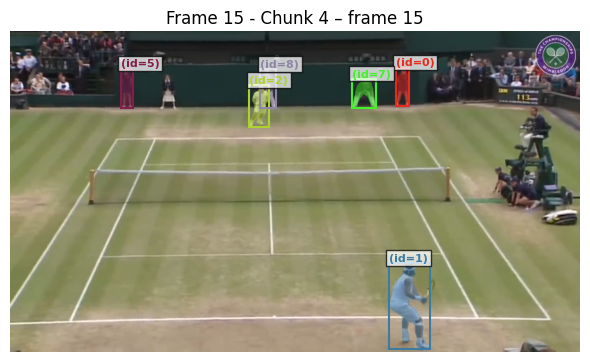

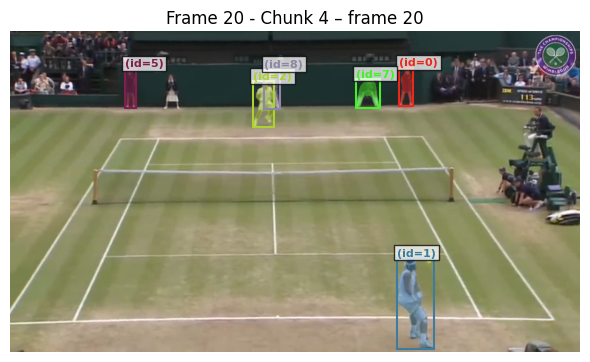

In [9]:
vis_frame_stride = 5  # show every Nth frame within each chunk

for chunk_idx, (outputs, obj_ids, frames_vis) in enumerate(chunk_results):
    print(f"\n── Chunk {chunk_idx} ── Object IDs: {sorted(obj_ids)}")
    vis_outputs = prepare_masks_for_visualization(outputs)
    plt.close("all")
    for frame_idx in range(0, len(vis_outputs), vis_frame_stride):
        visualize_formatted_frame_output(
            frame_idx,
            frames_vis,
            outputs_list=[vis_outputs],
            titles=[f"Chunk {chunk_idx} – frame {frame_idx}"],
            figsize=(6, 4),
        )

## Summary table

A compact view showing how object IDs map across chunks.

In [10]:
# Collect all global object IDs across all chunks
all_global_ids = set()
for _, obj_ids, _ in chunk_results:
    all_global_ids.update(obj_ids)
all_global_ids = sorted(all_global_ids)

print(f"{'Chunk':<8}", end="")
for gid in all_global_ids:
    print(f"{'obj_'+str(gid):>8}", end="")
print()
print("─" * (8 + 8 * len(all_global_ids)))

for chunk_idx, (outputs, obj_ids, _) in enumerate(chunk_results):
    print(f"{'  ' + str(chunk_idx):<8}", end="")
    for gid in all_global_ids:
        if gid in obj_ids:
            print(f"{'  ✓':>8}", end="")
        else:
            print(f"{'  ·':>8}", end="")
    print()

Chunk      obj_0   obj_1   obj_2   obj_3   obj_4   obj_5   obj_6   obj_7   obj_8
────────────────────────────────────────────────────────────────────────────────
  0            ✓       ✓       ✓       ·       ·       ·       ·       ·       ·
  1            ✓       ✓       ✓       ✓       ·       ·       ·       ·       ·
  2            ✓       ✓       ✓       ·       ✓       ·       ·       ·       ·
  3            ✓       ✓       ✓       ·       ·       ✓       ✓       ✓       ·
  4            ✓       ✓       ✓       ·       ·       ✓       ·       ✓       ✓
